# Final Project (part 3)
#### By Shubhankar Kumar

### 5. Identifying most popular as well as rapidly growing repositories

In [1]:
commits_df = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/commits")

In [2]:
from pyspark.sql.functions import col
selected_columns = ["author", "committer", "subject", "message", "repo_name", "commit", "difference"]
commits_df_selected = commits_df.select(*selected_columns)

commits_df_selected.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|              author|           committer|             subject|             message|           repo_name|              commit|difference|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|{conda-forge-coor...|{conda-forge-coor...|Updated the qceng...|Updated the qceng...|[conda-forge/feed...|aa358905a1b12c6fa...|        []|
|{Rob Allen, 7e09c...|{Rob Allen, 7e09c...|Merge remote-trac...|Merge remote-trac...|[MadCat34/zend-es...|5a6b6d6d29489f858...|        []|
|{Zhihui Zhang, 96...|{Zhihui Zhang, 96...|provide hook to o...|provide hook to o...|[pscedu/slash2-st...|6b6ac3b8ab7363b22...|        []|
|{conda-forge-coor...|{conda-forge-coor...|Updated the mailc...|Updated the mailc...|[conda-forge/feed...|e26e1f63938b983ce...|        []|
|{armaneshaghi, f6...|{arma

In [3]:
from pyspark.sql.functions import col, countDistinct, count, sum, explode

# Explode the 'difference' array to access individual struct elements
exploded_df = commits_df_selected.select("repo_name","author", 'commit', explode("difference").alias("diff"))

In [4]:
popular_repositories = exploded_df.groupBy("repo_name").agg(
    countDistinct("author.name").alias("contributors"),
    count("commit").alias("commits")
).orderBy(col("commits").desc())

popular_repositories.show(5, truncate=False)

+----------------------------------------------------------------------+------------+--------+
|repo_name                                                             |contributors|commits |
+----------------------------------------------------------------------+------------+--------+
|[coq-bench/coq-bench.github.io]                                       |2           |14929138|
|[frohoff/jdk8u-dev-jdk, frohoff/jdk8u-jdk]                            |208         |13591441|
|[cosnicsTHLU/cosnics, forelo/cosnics, cosnics/cosnics]                |21          |12911349|
|[kunj1988/Magento2]                                                   |1430        |12289455|
|[lambdalab-mirror/jdk7u-jdk, frohoff/jdk8u-dev-jdk, frohoff/jdk8u-jdk]|127         |11830438|
+----------------------------------------------------------------------+------------+--------+
only showing top 5 rows



Based on the above table, [coq-bench/coq-bench.github.io], [frohoff/jdk8u-dev-jdk] and [cosnicsTHLU/cosnics, forelo/cosnics, cosnics/cosnics] seem to be the most popular repositories

In [5]:
from pyspark.sql.functions import col, regexp_extract
commits_df_selected = commits_df_selected.withColumn(
    "date",
    col("committer.time_sec")
)
from pyspark.sql.functions import from_unixtime

commits_df_selected = commits_df_selected.withColumn("timestamp", from_unixtime("date"))
commits_df_selected = commits_df_selected.drop("date")
commits_df_selected = commits_df_selected.drop("truncated_timestamp")

In [6]:
commits_df_selected.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-------------------+
|              author|           committer|             subject|             message|           repo_name|              commit|difference|          timestamp|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-------------------+
|{conda-forge-coor...|{conda-forge-coor...|Updated the qceng...|Updated the qceng...|[conda-forge/feed...|aa358905a1b12c6fa...|        []|2022-03-15 15:11:13|
|{Rob Allen, 7e09c...|{Rob Allen, 7e09c...|Merge remote-trac...|Merge remote-trac...|[MadCat34/zend-es...|5a6b6d6d29489f858...|        []|2011-12-09 15:05:17|
|{Zhihui Zhang, 96...|{Zhihui Zhang, 96...|provide hook to o...|provide hook to o...|[pscedu/slash2-st...|6b6ac3b8ab7363b22...|        []|2011-04-27 17:17:23|
|{conda-forge-coor...|{conda-forge-coor...|Upd

In [7]:
from pyspark.sql.functions import col, dense_rank, desc
from pyspark.sql.window import Window

commit_counts = commits_df_selected.groupBy("repo_name").count()

# 2. Most Rapidly Growing Repositories (Based on Growth Rate of Commits)
window_spec = Window().orderBy(desc("count"))

# Rank repositories based on the number of commits
ranked_repos = commit_counts.withColumn(
    "rank",
    dense_rank().over(window_spec)
)

In [8]:
# Select the top 10 rapidly growing repositories
rapidly_growing_repos = ranked_repos.filter(col("rank") <= 10)

# Display the most rapidly growing repositories
rapidly_growing_repos.show(truncate=False)

23/12/04 20:12:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 20:12:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 20:13:11 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 20:14:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 20:14:06 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

+--------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+----+
|repo_name                                                                                                                                                     |count  |rank|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+----+
|[shenzhouzd/update]                                                                                                                                           |1188563|1   |
|[duaneking/rockstar_test]                                                                                                                                     |597894 |2   |
|[Dark5ide/mycroft-core]                                                                                                          

23/12/04 20:14:11 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 20:14:11 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 20:15:15 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 20:16:09 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 20:16:09 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

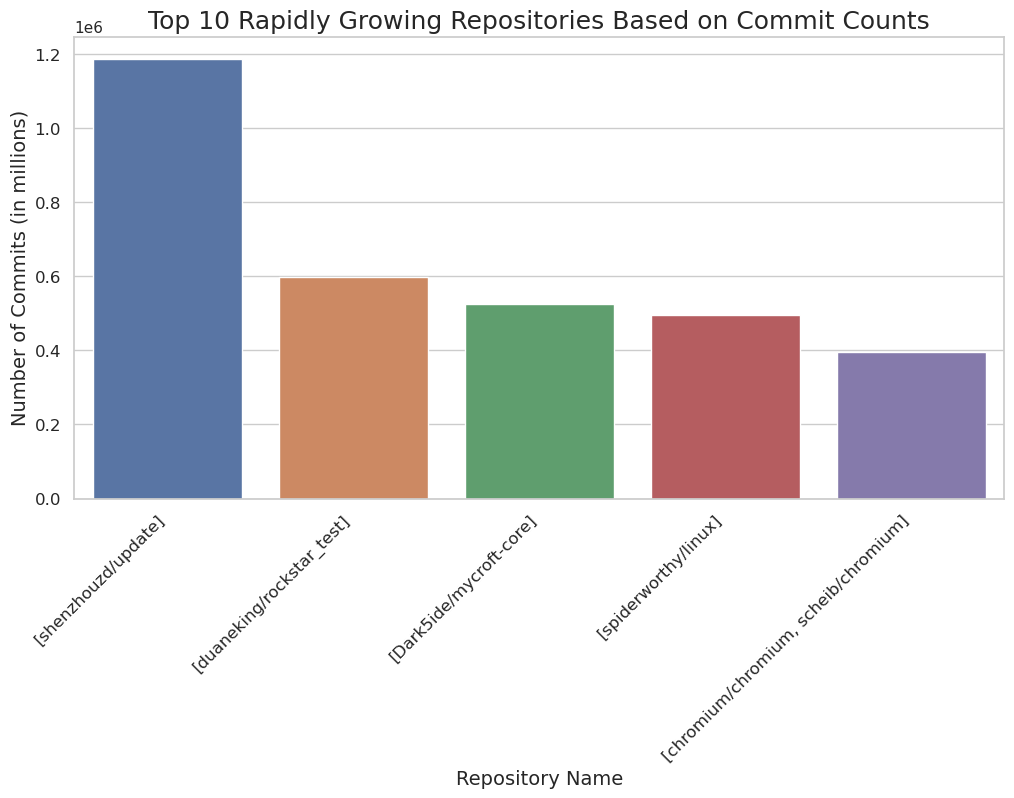

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

rapidly_growing_repos = rapidly_growing_repos.withColumn("repo_name_str", col("repo_name").cast("string"))
top5_rapidly_growing_repos = rapidly_growing_repos.filter(col("rank") <= 5)
# Convert Spark DataFrame to Pandas DataFrame for plotting
rapidly_growing_repos_pd = top5_rapidly_growing_repos.toPandas()

# Set the style of seaborn for better aesthetics (optional)
sns.set(style="whitegrid")

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x="repo_name_str", y="count", data=rapidly_growing_repos_pd)
plt.title('Top 10 Rapidly Growing Repositories Based on Commit Counts', fontsize=18)
plt.xlabel('Repository Name', fontsize=14)
plt.ylabel('Number of Commits (in millions)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [10]:
commits_df_selected.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-------------------+
|              author|           committer|             subject|             message|           repo_name|              commit|difference|          timestamp|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-------------------+
|{conda-forge-coor...|{conda-forge-coor...|Updated the qceng...|Updated the qceng...|[conda-forge/feed...|aa358905a1b12c6fa...|        []|2022-03-15 15:11:13|
|{Rob Allen, 7e09c...|{Rob Allen, 7e09c...|Merge remote-trac...|Merge remote-trac...|[MadCat34/zend-es...|5a6b6d6d29489f858...|        []|2011-12-09 15:05:17|
|{Zhihui Zhang, 96...|{Zhihui Zhang, 96...|provide hook to o...|provide hook to o...|[pscedu/slash2-st...|6b6ac3b8ab7363b22...|        []|2011-04-27 17:17:23|
|{conda-forge-coor...|{conda-forge-coor...|Upd

### 6. Identifying reasons for committing into GitHub repositories

In [11]:
from pyspark.sql.functions import col, lower, explode, split, expr, concat_ws
commit_messages_df = commits_df_selected.select("message")

lowercased_messages_df = commit_messages_df.select(lower(col("message")).alias("message"))

# Split the commit messages into words
words_df = lowercased_messages_df.select(explode(split(col("message"), " ")).alias("word"))

# Define keywords associated with different types of commits (you can expand this list)
keywords = {
    "feature": ["feature", "new", "added", "implemented", "updated"],
    "bug_fix": ["fixed", "bug", "resolve", "issue", "fix", "resolved"],
    "documentation": ["doc", "documentation", "readme"],
    "refactor": ["refactor", "restructure", "refactored", "restructured"],
    # Add more categories as needed
}

categorized_df = words_df.withColumn("category", 
                    concat_ws("|", *[expr("CASE WHEN word = '{}' THEN '{}' END".format(kw, cat))
                                    for cat, kws in keywords.items() for kw in kws] +
                                    [expr("CASE WHEN {} THEN 'other' END".format(
                                        ' AND '.join("word != '{}'".format(kw) for kws in keywords.values() for kw in kws)
                                    ))]))

# Filter out rows without a category
filtered_categorized_df = categorized_df.filter(col("category").isNotNull())

# Calculate the count of each category
category_counts = filtered_categorized_df.groupBy("category").count().orderBy(col("count").desc())

In [12]:
category_counts.show(truncate=False)

+-------------+----------+
|category     |count     |
+-------------+----------+
|other        |2923511998|
|bug_fix      |35133263  |
|feature      |34161094  |
|documentation|3415992   |
|refactor     |1707721   |
+-------------+----------+



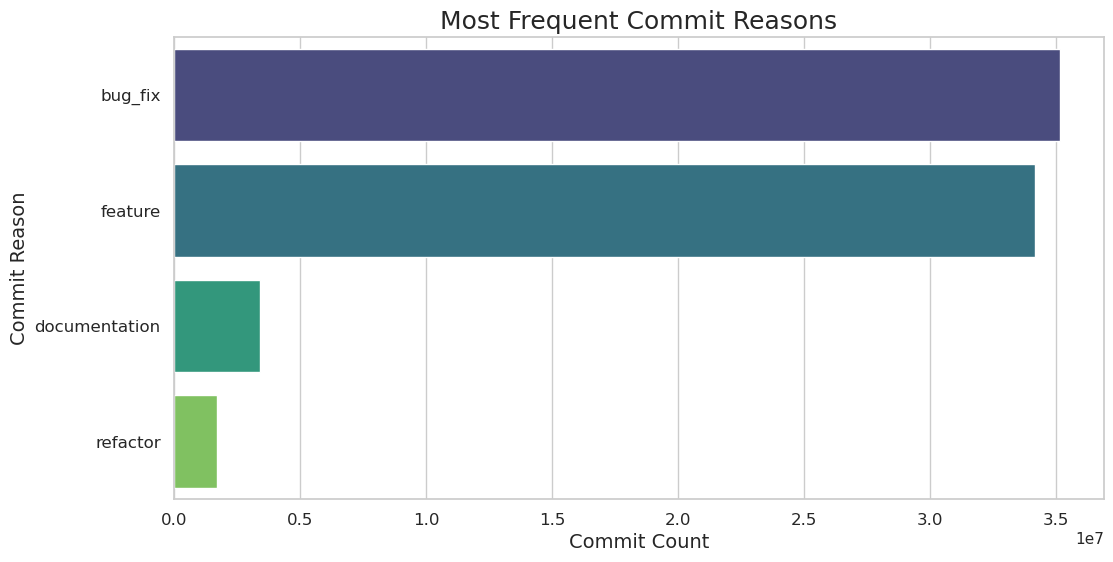

In [13]:
category_counts_pd = category_counts.toPandas()
filtered_category_counts_pd = category_counts_pd[category_counts_pd['category'] != 'other']

# Plot the bar chart for commit categories excluding "other"
plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="category", data=filtered_category_counts_pd, palette="viridis")
plt.title('Most Frequent Commit Reasons', fontsize=18)
plt.xlabel('Commit Count', fontsize=14)
plt.ylabel('Commit Reason', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()